# Single neuron TB

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import importlib
from spiker import *
from IPython.display import clear_output, Image, display, HTML
import seaborn as sns
import matplotlib.patches as mpatches

sns.set_style('whitegrid')
# Test bench for Neuron
# Ip -> Neuron -> Syn -> Vsyn
Ts = 1e-6
transient_time = 0.1
def run_test(freq=5, amp=1e-9, periods = 1, plt = False, verbose=False):
    tstart = 0
    tstop = transient_time + periods/freq
    print(f'Running test with freq = {freq} and amplitude = {amp} for time {tstop}s' )
    
    tseries = gen_time(tstart,tstop,Ts)
    ipt     = gen_sine(tseries, freq, amp=amp)
    
    nspikes = np.zeros_like(tseries.time)
    nfbsyn  = np.zeros_like(tseries.time)
    nesyn   = np.zeros_like(tseries.time)
    nipsyn  = np.zeros_like(tseries.time)
    
    ipt.set_time(0.)
    n = Neuronv2(1,Ts=Ts,
        ipItau   = 10e-12,
        ipIth    = 10e-12,
        fbItau   = 10e-12,
        fbIth    = 10e-12,
        fbdelta  = 0.1e-9,
        eItau    = 10e-12,
        eIth     = 100000e-12,
        thresh   = 0,  
        Kappa    = 0.7, 
        Temp     = 300,
        ipCmem   = 2e-12,
        fbCmem   = 2e-12,
        eCmem    = 2e-12,
        Tp       = Ts,
        mode     = 'sd',
        refr     = 1e-3,
        mismatch = 0)
    
    for index in range(len(tseries.time)):
        ip = ipt.value[index]
        nop = n.compute(ip)
        nspikes[index] = n.states[0]
        nfbsyn[index] = n.frecon[0]
        nesyn[index] = n.esyn.states[0]
        nipsyn[index] = n.irecon[0]
    if plt:
        nspikes_t = Tseries(nspikes,tseries.time,Ts)    
        nfbsyn_t  = Tseries(nfbsyn,tseries.time,Ts)  
        nfbsyn_t.plot(0,tstop)
        ipt.plot(0,tstop)
    if verbose:
        n.print_props()
    return ipt.value, nfbsyn, n.spike_count/tstop, nesyn, nipsyn, nspikes

def compute_sdr(ip, Ts, plt = False, verbose=False):
    # Measuring the signal quality
    ip_fft = np.fft.fft(ip)
    N = len(ip_fft)
    ip_fft_psd = 2*np.abs(ip_fft)**2

    freqs = np.linspace(0.0, int(1.0/(2.0*Ts)), int(N/2))
    if plt:
        plt.semilogx(freqs, 10*np.log10(ip_fft_psd[:N//2]))
    max_id = 1+np.argmax(ip_fft_psd[1:N//2])
    peak_freq = freqs[max_id] 
    total_energy = np.sum(ip_fft_psd[1:N//2]) # discount the DC component
    distortion_energy = total_energy - ip_fft_psd[max_id]
    sdr = (ip_fft_psd[max_id])/distortion_energy
    sdr_db = 10*np.log10(sdr)
    if verbose:
        print(f'Peak frequency is {1+peak_freq} Hz')
        print(f'SDR in dB is {10*np.log10(sdr)}')
        print('='*89)
    return sdr_db

In [6]:
ip, nfb, frate, ne, nip, ns = run_test(10, 1e-9, verbose=True)

Running test with freq = 10 and amplitude = 1e-09 for time 0.2s
------------------

Neuron properties

Delta =  [0.]
Step time =  1e-06
------------------

Input DPI properties

Step time =  1e-06
Time constant =  0.007386283149874306
Pole freq =  135.38609063707736
Gain =  1.0
------------------

Feedback DPI properties

Step time =  1e-06
Time constant =  0.007386283149874306
Pole freq =  135.38609063707736
Gain =  1.0
Delta =  1e-10
Spike Width =  1
------------------

Error DPI properties

Step time =  1e-06
Time constant =  0.007386283149874306
Pole freq =  135.38609063707736
Gain =  10000.0
------------------

Number of spikes = 541.0

------------------



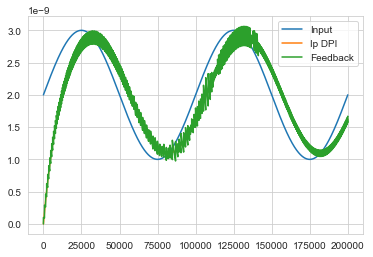

In [14]:
start_idx = 0#-100000
stop_idx = -1#-9000
plt.plot(ip[start_idx:stop_idx], label='Input')
plt.plot(nip[start_idx:stop_idx], label='Ip DPI')
plt.plot(nfb[start_idx:stop_idx], label='Feedback')
# plt.plot(ne[start_idx:stop_idx], label='Error DPI')
plt.legend()

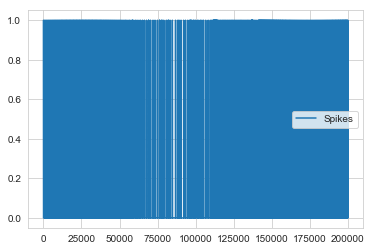

In [13]:
start_idx = 0#-10000
stop_idx = -1#1000
plt.plot(ns[start_idx:stop_idx], label='Spikes')
# plt.plot(ne[start_idx:stop_idx], label='Error DPI')
plt.legend()